In [1]:
pip install "dask[dataframe]"

Looking in indexes: https://mirrors.aliyun.com/pypi/simple
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install "dask[distributed]"

Looking in indexes: https://mirrors.aliyun.com/pypi/simple
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import os
import ast
import re
import json
from icecream import ic
from copy import deepcopy
from itertools import product, combinations, permutations
from collections import defaultdict

In [458]:
import pandas as pd
import os
import sys
from pyarrow.filesystem import LocalFileSystem
from functools import reduce
import nltk
from nltk import pos_tag, word_tokenize
from collections import namedtuple
from ast import literal_eval

from torch.nn import functional
import numpy as np
import torch
from torch import nn
from torch.nn import init
from torch.nn.utils import rnn as rnn_utils
import math

from icecream import ic
import seaborn as sns

import matplotlib.pyplot as plt

import shutil
import jieba

from snorkel.labeling import labeling_function
from glob import glob

import pickle as pkl

from snorkel.labeling.model import LabelModel
from snorkel.labeling import PandasLFApplier
from snorkel.labeling.apply.dask import PandasParallelLFApplier
from sklearn.metrics import balanced_accuracy_score
from functools import partial

In [5]:
pd.set_option("display.max_rows", 100)

In [6]:
train_path = "../TableQA/TableQA/train"
def data_loader(table_json_path = os.path.join(train_path ,"train.tables.json"),
                json_path = os.path.join(train_path ,"train.json"),
                req_table_num = 1):
    assert os.path.exists(table_json_path)
    assert os.path.exists(json_path)
    json_df = pd.read_json(json_path, lines = True)
    all_tables = pd.read_json(table_json_path, lines = True)
    if req_table_num is not None:
        assert type(req_table_num) == type(0) and req_table_num > 0 and req_table_num <= all_tables.shape[0]
    else:
        req_table_num = all_tables.shape[0]
    for i in range(req_table_num):
        #one_table = all_tables.iloc[i]["table"]
        #one_table_df = pd.read_sql("select * from `{}`".format(one_table), train_tables_dump_engine)
        one_table_s = all_tables.iloc[i]
        one_table_df = pd.DataFrame(one_table_s["rows"], columns = one_table_s["header"])
        yield one_table_df, json_df[json_df["table_id"] == one_table_s["id"]]

In [7]:
#### used in this condition extract in training.
op_sql_dict = {0:">", 1:"<", 2:"==", 3:"!="}
#### used by clf for intension inference
agg_sql_dict = {0:"", 1:"AVG", 2:"MAX", 3:"MIN", 4:"COUNT", 5:"SUM"}
#### final to combine them (one for 0, and multi for 1 2)
conn_sql_dict = {0:"", 1:"and", 2:"or"}

In [8]:
first_train_df ,first_train_question_df = list(data_loader(req_table_num = 1))[0]

In [9]:
question = first_train_question_df.iloc[0]["question"].strip()
sql = first_train_question_df.iloc[0]["sql"]

In [10]:
sql

{'agg': [0], 'cond_conn_op': 0, 'sel': [1], 'conds': [[2, 1, '1000']]}

In [11]:
question

'成交楼面均价小于1000的规划建筑面积是多少'

In [12]:
first_train_df.columns.tolist()
# cond_conn_op

['300城市土地出让', '规划建筑面积(万㎡)', '成交楼面均价(元/㎡)', '平均溢价率(%)', '土地出让金(亿元)', '同比']

In [13]:
def extract_conds_and_question_column(s, header):
    assert type(s) == type(pd.Series())
    assert type(header) == type([])
    sql = s.loc["sql"]
    def sql_dict_lookup_header(sql_dict):
        assert type(sql_dict) == type(dict())
        return dict(
                    map(lambda t2: (t2[0] ,
                        ((list(
                            map(lambda idx: header[idx], t2[1])) 
                              if (t2[0] != "agg") 
                                  else t2[1]) 
                                     if isinstance(t2[1], list) 
                                         else( header[t2[1]]) 
                                             if t2[0] != "cond_conn_op" 
                                                 else t2[1])if t2[0] != "conds" 
                                                    else list(
                                                        map(lambda inner_list: [header[inner_list[0]]] + inner_list[1:], t2[1]))), 
                                                            sql_dict.items()))
    sql_header_trans_dict = sql_dict_lookup_header(sql)
    agg = sql_header_trans_dict["agg"]
    cond_conn_op = sql_header_trans_dict["cond_conn_op"]
    question_column_list = sql_header_trans_dict["sel"]
    conds = sql_header_trans_dict["conds"]
    conds_text_extract = list(set(filter(lambda x: x != "None" ,map(str ,reduce(lambda a, b: a + b ,map(lambda t3: (t3[0], t3[2]), conds))))))
    question = s.loc["question"].strip()
    return question ,sql_header_trans_dict, agg, cond_conn_op, question_column_list, conds_text_extract

In [14]:
conclusion = extract_conds_and_question_column(first_train_question_df.iloc[0], first_train_df.columns.tolist())
question ,sql_header_trans_dict, agg, cond_conn_op, question_column_list, conds_text_extract = conclusion

/environment/python/versions/miniconda3-4.7.12/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [15]:
def findMaxSubString(str1, str2):
    """
    """
    maxSub = 0
    maxSubString = ""
 
    str1_len = len(str1)
    str2_len = len(str2)
 
    for i in range(str1_len): 
        str1_pos = i
        for j in range(str2_len):
            str2_pos = j
            str1_pos = i
            if str1[str1_pos] != str2[str2_pos]:
                continue
            else:
                while (str1_pos < str1_len) and (str2_pos < str2_len):
                    if str1[str1_pos] == str2[str2_pos]:
                        str1_pos = str1_pos + 1
                        str2_pos = str2_pos + 1
                    else:
                        break
 
                sub_len = str2_pos - j 
                if maxSub < sub_len:
                    maxSub = sub_len
                    maxSubString = str2[j:str2_pos]
    return maxSubString

In [16]:
def feature_construction(question, question_column_list, conds_text_extract):
    assert type(question) == type("")
    assert isinstance(question_column_list, list) and isinstance(conds_text_extract, list)
    def replace_by_list(text, input_list):
        req = text.strip()
        for rm_ele in input_list:
            req = req.replace(rm_ele, "")
        return req    
    rep_qes_string = replace_by_list(question, list(map(lambda x: findMaxSubString(question, x), question_column_list)))
    rep_conds_string = replace_by_list(question, list(map(lambda x: findMaxSubString(question, x), conds_text_extract)))
    rep_all_string = findMaxSubString(rep_qes_string, rep_conds_string)
    ##### four feature construct
    return rep_all_string, rep_qes_string, rep_conds_string, question

In [17]:
feature_construction(question, question_column_list, conds_text_extract)

('是多少', '成交楼面均价小于1000的是多少', '小于的规划建筑面积是多少', '成交楼面均价小于1000的规划建筑面积是多少')

In [18]:
def agg_classifier_data_loader(table_json_path = os.path.join(train_path ,"train.tables.json"),
                json_path = os.path.join(train_path ,"train.json"),
                req_table_num = 1):
    for train_df ,train_question_df in data_loader(table_json_path , json_path, req_table_num):
        header = train_df.columns.tolist()
        for conclusion in train_question_df.apply(lambda s: extract_conds_and_question_column(s, header), axis = 1).tolist():
            question ,sql_header_trans_dict, agg, cond_conn_op, question_column_list, conds_text_extract = conclusion
            t4_feature = feature_construction(question, question_column_list, conds_text_extract)
            yield {
                "feature": t4_feature,
                "agg": agg,
                "cond_conn_op": cond_conn_op
            }

In [19]:
train_agg_df = pd.DataFrame(list(agg_classifier_data_loader(req_table_num=None)))

/environment/python/versions/miniconda3-4.7.12/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [20]:
def standlize_agg_column(agg_df):
    req = agg_df.copy()
    req["agg"] = req["agg"].map(lambda agg_list: agg_list[0] if (len(agg_list) == 1 or len(set(agg_list)) == 1) else np.nan)
    return req.dropna()

In [21]:
train_agg_std_df = standlize_agg_column(train_agg_df)

In [22]:
train_agg_df.shape ,train_agg_std_df.shape

((41522, 3), (41519, 3))

In [345]:
#

In [23]:
#### not balance and other info small try kws rule method first
train_agg_std_df["agg"].value_counts()

0.0    36500
4.0     2899
5.0      995
1.0      504
2.0      373
3.0      248
Name: agg, dtype: int64

In [24]:
#agg_sql_dict
dict(map(lambda t2: (agg_sql_dict[int(t2[0])], t2[1]) ,train_agg_std_df["agg"].value_counts().to_dict().items()))

{'': 36500, 'COUNT': 2899, 'SUM': 995, 'AVG': 504, 'MAX': 373, 'MIN': 248}

In [25]:
train_agg_std_df["feature_cut"] = train_agg_std_df.apply(lambda s: tuple(map(lambda str_: tuple(jieba.cut(str_)), s.loc["feature"])), axis = 1)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.456 seconds.
Prefix dict has been built successfully.


In [26]:
##### use res part (rep_all_string) to collect kws
train_agg_std_res_cut_df = pd.DataFrame(train_agg_std_df[["agg" ,"feature_cut"]].apply(lambda s: (s.loc["agg"], s.loc["feature_cut"][0]), axis = 1).values.tolist())
train_agg_std_res_cut_df.columns = ["agg", "res_cut"]

In [27]:
#res_cut_s = pd.Series(reduce(lambda a, b : a + b,train_agg_std_res_cut_df["res_cut"].tolist()))

In [28]:
def agg_label_res_cut_cnt(df, agg_label = 0):
    needed = df[df["agg"] == agg_label]
    return pd.Series(reduce(lambda a, b : a + b,needed["res_cut"].tolist())).value_counts()

In [29]:
agg_label_cut_stats = dict(map(lambda agg_label: (agg_label, agg_label_res_cut_cnt(train_agg_std_res_cut_df, agg_label)) ,train_agg_std_df["agg"].unique().tolist()))

In [30]:
def transform_stats_to_df(stats_dict, standlize = True):
    assert type(stats_dict) == type(dict())
    header = list(stats_dict.keys())
    def add_cols(df, columns):
        df.columns = columns
        return df
    req = reduce(lambda a, b: pd.merge(a, b, on = "word", how = "outer") ,map(lambda c: add_cols(stats_dict[c].reset_index(), ["word", c]), header)).fillna(0.0)
    req = req[["word"]+sorted(header)]
    req.index = req["word"]
    del req["word"]
    if standlize:
        req = req / req.sum(axis = 0)
    return req

In [31]:
agg_label_cut_stats_df = transform_stats_to_df(agg_label_cut_stats)

In [32]:
agg_label_cut_stats_df["agg_dist_std"] = agg_label_cut_stats_df.apply(lambda s: s.std(), axis = 1)

In [33]:
agg_label_cut_stats_df["max_evidence_agg_label"] = agg_label_cut_stats_df[[0.0, 1.0, 2.0, 3.0, 4.0, 5.0]].apply(lambda s: s.argmax(), axis = 1)

In [34]:
agg_label_cut_stats_df["max_first_second_agg_evidence"] = agg_label_cut_stats_df[[0.0, 1.0, 2.0, 3.0, 4.0, 5.0]].apply(lambda s: max(s) - s.sort_values(ascending = False).iloc[1], axis = 1)

In [35]:
agg_label_cut_stats_df["max_first_all_ratio_agg_evidence"] = agg_label_cut_stats_df[[0.0, 1.0, 2.0, 3.0, 4.0, 5.0]].apply(lambda s: max(s) / sum(s), axis = 1)

In [36]:
agg_label_cut_stats_df.sort_values(by = "agg_dist_std", ascending=False).head(10)

,0.0,1.0,2.0,3.0,4.0,5.0,agg_dist_std,max_evidence_agg_label,max_first_second_agg_evidence,max_first_all_ratio_agg_evidence
word,,,,,,,,,,
有,0.026991,0.004430,0.007519,0.003157,0.100836,0.030167,0.037145,4,0.070670,0.582532
平均,0.001179,0.055696,0.004423,0.011995,0.000896,0.000000,0.021681,1,0.043701,0.750736
多少,0.021808,0.072785,0.066785,0.064394,0.071804,0.082833,0.021348,5,0.010049,0.217748
最大,0.000000,0.000000,0.045997,0.000000,0.000000,0.000000,0.018778,2,0.045997,1.000000
一共,0.000589,0.000000,0.000000,0.000000,0.025329,0.039333,0.017201,5,0.014005,0.602798
最小,0.000000,0.000000,0.000000,0.040404,0.000000,0.000000,0.016495,3,0.040404,1.000000
是,0.053250,0.055696,0.044228,0.039141,0.011947,0.034333,0.015870,1,0.002446,0.233433
的,0.066145,0.077215,0.075188,0.087753,0.048566,0.057500,0.014247,3,0.010537,0.212802
个,0.001184,0.001266,0.001327,0.000000,0.034170,0.002167,0.013482,4,0.032003,0.851829


In [37]:
##### max_first_second_agg_evidence have more performance than std
agg_label_cut_stats_df.sort_values(by = "max_first_second_agg_evidence", ascending=False).head(10)

,0.0,1.0,2.0,3.0,4.0,5.0,agg_dist_std,max_evidence_agg_label,max_first_second_agg_evidence,max_first_all_ratio_agg_evidence
word,,,,,,,,,,
有,0.026991,0.004430,0.007519,0.003157,0.100836,0.030167,0.037145,4,0.070670,0.582532
最大,0.000000,0.000000,0.045997,0.000000,0.000000,0.000000,0.018778,2,0.045997,1.000000
平均,0.001179,0.055696,0.004423,0.011995,0.000896,0.000000,0.021681,1,0.043701,0.750736
最小,0.000000,0.000000,0.000000,0.040404,0.000000,0.000000,0.016495,3,0.040404,1.000000
个,0.001184,0.001266,0.001327,0.000000,0.034170,0.002167,0.013482,4,0.032003,0.851829
什么,0.026606,0.000316,0.000442,0.000000,0.000239,0.000167,0.010768,0,0.026163,0.958072
哪些,0.026810,0.000316,0.000000,0.000000,0.001553,0.000000,0.010809,0,0.025256,0.934809
最低,0.000099,0.000000,0.000000,0.022096,0.000000,0.000000,0.009013,3,0.021997,0.995533
起来,0.000022,0.000316,0.000000,0.000000,0.000119,0.021667,0.008809,5,0.021350,0.979301


In [38]:
kws_evidence_df = agg_label_cut_stats_df.sort_values(by = "max_first_all_ratio_agg_evidence", ascending=False)[(
    agg_label_cut_stats_df["max_first_second_agg_evidence"] > 0.001) & (agg_label_cut_stats_df["agg_dist_std"] > 0.001)
& (agg_label_cut_stats_df["max_evidence_agg_label"] != 0.0)
]

/environment/python/versions/miniconda3-4.7.12/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [39]:
kws_evidence_rds_df = kws_evidence_df["max_evidence_agg_label"].reset_index().groupby("max_evidence_agg_label")["word"].apply(list).reset_index()

In [40]:
kws_evidence_rds_df.index = kws_evidence_rds_df["max_evidence_agg_label"]

In [41]:
kws_dict_before_dict = kws_evidence_rds_df.to_dict()["word"]

In [42]:
#kws_dict_before_dict

In [43]:
#### remove some common words from kws_evidence_rds_df by head 
### + ["几"] is to improve by observe below "train_agg_std_df_not_match_kws"
### the element in + ["以上", "大于"] have small evidence,
### and only for improve recall, they may have bad effect on precision
### because some conflict with condition.
kws_dict_after_dict = {1: ['平均数', '均值', '平均值', '平均',],
 2: ['最大',
  '最多',
  '最大值',
  '最高',
  ] + ["以上", "大于"],
 3: ['最少',
  '最小值',
  '最小',
  '最低',
  ] + ["以下", "小于"],
 4: ['几家', '个', '几个', '总共'] + ["几"] + ["哪些", "查", "数量", "数"],
 5: [
  '总和',
  '加',
  '总',
  '一共',
  '和',
  '多少',
  ] + ["多大"]}

In [44]:
#### 4 and 5 may have some confusion, this relate with column dtype ("SUM" may mainly to float column, 
#### "COUNT" may not have this contrain)
#### 1, 2, 3 only can apply to float dtype column
#### so the question_column dtype is also a important feature
#### this will use as a rule
kws_dict_after_dict

{1: ['平均数', '均值', '平均值', '平均'],
 2: ['最大', '最多', '最大值', '最高', '以上', '大于'],
 3: ['最少', '最小值', '最小', '最低', '以下', '小于'],
 4: ['几家', '个', '几个', '总共', '几', '哪些', '查', '数量', '数'],
 5: ['总和', '加', '总', '一共', '和', '多少', '多大']}

In [45]:
##### explore the performance or drawback of kws, improve it.

In [46]:
all_kws = reduce(lambda a, b: a + b ,kws_dict_after_dict.values())
train_agg_std_df_not_match_kws = train_agg_std_df[train_agg_std_df["agg"] != 0.0][train_agg_std_df[train_agg_std_df["agg"] != 0.0]["feature"].map(lambda t4: sum(map(lambda kw: kw in t4[-1], all_kws)) == 0)].copy()

In [47]:
##### kws justify should apply to question (total part directly)
##### can match 99.8% sample (sense of recall)
train_agg_std_df[train_agg_std_df["agg"] != 0.0].shape ,train_agg_std_df_not_match_kws.shape, 1 - train_agg_std_df_not_match_kws.shape[0] / train_agg_std_df[train_agg_std_df["agg"] != 0.0].shape[0] 

((5019, 4), (7, 4), 0.99860529986053)

In [48]:
pd.DataFrame(train_agg_std_df_not_match_kws.apply(lambda s: (s["feature"][-1], s["agg"]), axis = 1))

,0
4262,"(有没有一线城市去化时间近两周都不足半年的城市, 4.0)"
13898,"(你能告诉我五月天的后来的我们这首歌的点播率多高吗？, 4.0)"
14166,"(你能不能告诉我收视率在1月18日的时候超过0.3%或者市场份额超过3%的综艺节目名称, 4.0)"
16035,"(你知道中共中央对外联络部或者部内司局的职位名称吗，可以告诉我吗, 4.0)"
16673,(那些规格型号是168g/袋或者生产日期/批号是2017.12.23的食品标识生产企业名称，...
36312,"(你知道企业代码为77563560-X或者住所是浙江省诸暨市大唐镇开元东路的企业名称吗, 4.0)"
36979,"(你好啊，你知道万能型的都是什么保险产品吗, 4.0)"


In [49]:
#### snorkel on kws

In [50]:
agg_sql_dict

{0: '', 1: 'AVG', 2: 'MAX', 3: 'MIN', 4: 'COUNT', 5: 'SUM'}

In [51]:
# Define the label mappings for convenience
#### ABSTAIN can not guess if finance
#ABSTAIN = -1
NONE = 0
AVG = 1
MAX = 3
MIN = 4
COUNT = 5
SUM = 6

In [52]:
kws_dict_after_dict = {1: ['平均数', '均值', '平均值', '平均',],
 2: ['最大',
  '最多',
  '最大值',
  '最高',
  ] + ["以上", "大于"],
 3: ['最少',
  '最小值',
  '最小',
  '最低',
  ] + ["以下", "小于"],
 4: ['几家', '个', '几个', '总共'] + ["几"] + ["哪些", "查", "数量", "数"],
 5: [
  '总和',
  '加',
  '总',
  '一共',
  '和',
  '多少',
  ] + ["多大"]}

In [53]:
kws_tuple_key_dict = {
    ('平均数', '均值', '平均值', '平均',): 1,
    
    ('最大','最多','最大值','最高',):2,
    ("以上", "大于"): 2,
    
    ('最少','最小值','最小','最低'):3,
    ("以下", "小于"): 3,
    
    ('个', '总共'): 4,
    ("几",):4,
    ("哪些", "查", "数量", "数"): 4,
    
    ('总和','加','总','一共','和',):5,
    ('多少', "多大"): 5
}

In [54]:
kws_key_list_tuple_dict = defaultdict(list)
for tuple_, k in kws_tuple_key_dict.items():
    kws_key_list_tuple_dict[k].append(tuple_)

In [55]:
#### if you only can not think which order rule is the best than,
### use product to product rule element and use permutations to simulate all
### take a look at L_train of snorkel
different_rule_product_list = list(product(*list(map(lambda t2: t2[1] ,sorted(kws_key_list_tuple_dict.items(), key = lambda t2: t2[0])))))

In [56]:
def kw_matcher(text_tokens):
    if any(map(lambda kw: kw in text_tokens, ('平均数', '均值', '平均值', '平均'))):
        return 1
    if any(map(lambda kw: kw in text_tokens, ('最大', '最多', '最大值', '最高'))):
        return 2
    if any(map(lambda kw: kw in text_tokens, ('最少', '最小值', '最小', '最低'))):
        return 3
    if any(map(lambda kw: kw in text_tokens, ('个', '总共'))):
        return 4
    if any(map(lambda kw: kw in text_tokens, ('总和', '加', '总', '一共', '和'))):
        return 5
    return 0

In [57]:
kw_matcher_func_format = "def kw_matcher_{}(s):\n\tif any(map(lambda kw: kw in text_tokens, {})):\n\t\treturn {}\n\tif any(map(lambda kw: kw in text_tokens, {})):\n\t\treturn {}\n\tif any(map(lambda kw: kw in text_tokens, {})):\n\t\treturn {}\n\tif any(map(lambda kw: kw in text_tokens, {})):\n\t\treturn {}\n\tif any(map(lambda kw: kw in text_tokens, {})):\n\t\treturn {}\n\treturn {}"

In [58]:
print(kw_matcher_func_format)

def kw_matcher_{}(s):
	if any(map(lambda kw: kw in text_tokens, {})):
		return {}
	if any(map(lambda kw: kw in text_tokens, {})):
		return {}
	if any(map(lambda kw: kw in text_tokens, {})):
		return {}
	if any(map(lambda kw: kw in text_tokens, {})):
		return {}
	if any(map(lambda kw: kw in text_tokens, {})):
		return {}
	return {}


In [59]:
def one_rule_if_else_generate(rule_list):
    assert type(rule_list) == type((1,))
    assert type(rule_list[0]) == type((1,))
    #### t2 key as kws_key t2 val as kws tuple_
    rule_items = list(map(lambda t2: (t2[0] + 1, t2[1]), enumerate(rule_list)))
    rule_list_perm_iter = permutations(rule_items)
    for perm_rule_items in rule_list_perm_iter:
        yield perm_rule_items

In [60]:
#### generate labeling func 
func_index = 0
for i_, rule_list in enumerate(sorted(different_rule_product_list)):
    for t5 in one_rule_if_else_generate(rule_list):
        '''
        func_format_tuple = (func_index,) + \
            reduce(lambda a, b: a + b ,map(lambda tt2: (tt2[1], tt2[0]) ,sorted(t5, key = lambda t2: t2[0]))) + \
                (0,)
        '''
        #ic(t5)
        func_format_tuple = (func_index,) + \
            reduce(lambda a, b: a + b ,map(lambda tt2: (tt2[1], tt2[0]) ,t5)) + \
                (0,)
        #print(func_format_tuple)
        #print(kw_matcher_func_format.format(*func_format_tuple))
        func_def = ("@labeling_function()\n" + kw_matcher_func_format.replace("text_tokens", "s.question_cut")).format(*func_format_tuple)
        #ic(func_def)
        func_index += 1
        exec(func_def.strip())
        #break
    #break

In [61]:
kw_matcher_func_list = list(map(lambda fname: eval(fname) ,filter(lambda x: callable(eval(x)) and x.startswith("kw_matcher_"), dir())))

In [62]:
pd.Series([list(jieba.cut("房地产板块个股的平均收益是多少？"))], index = ["question_cut"])

question_cut    [房地产, 板块, 个股, 的, 平均, 收益, 是, 多少, ？]
dtype: object

In [63]:
#### good case 
kw_matcher_0(pd.Series([list(jieba.cut("房地产板块个股的平均收益是多少？"))], index = ["question_cut"]))

1

In [64]:
#### bad case, as above discussion, may have bed effect on precision
kw_matcher_0(pd.Series([list(jieba.cut("房地产板块个股的收益是多少？"))], index = ["question_cut"]))

5

In [65]:
#### but some others may fix it
#tokens = list(jieba.cut("房地产板块个股的收益是多少？"))
tokens = pd.Series([list(jieba.cut("房地产板块个股的收益是多少？"))], index = ["question_cut"])
pd.Series(list(map(lambda f: f(tokens), kw_matcher_func_list))).value_counts()

0    1440
5    1440
dtype: int64

In [66]:
#### let snorkel choose the best

In [67]:
snokel_train_df = pd.DataFrame(train_agg_std_df[["feature", "agg"]].apply(lambda s: (s.loc["feature"][-1].strip(), s.loc["agg"]), axis = 1).values.tolist())
snokel_train_df.columns = ["question", "agg"]

In [68]:
snokel_train_df["question_cut"] = snokel_train_df["question"].map(jieba.cut).map(list)

In [69]:
snokel_train_df.head()

,question,agg,question_cut
0,成交楼面均价小于1000的规划建筑面积是多少,0.0,"[成交, 楼面, 均价, 小于, 1000, 的, 规划, 建筑面积, 是, 多少]"
1,成交楼面均价不大于1000规划建筑面积是有多大,0.0,"[成交, 楼面, 均价, 不, 大于, 1000, 规划, 建筑面积, 是, 有, 多, 大]"
2,成交楼面均价小于1000有多大的规划建筑面积,0.0,"[成交, 楼面, 均价, 小于, 1000, 有, 多, 大, 的, 规划, 建筑面积]"
3,规划建筑面积大于 100000或土地出让金大于 20000亿元的同比平均是多少？,1.0,"[规划, 建筑面积, 大于, , 100000, 或, 土地, 出让金, 大于, , 2..."
4,请问规划建筑面积大于 100000或土地出让金大于 20000亿元的同比平均是多少？,1.0,"[请问, 规划, 建筑面积, 大于, , 100000, 或, 土地, 出让金, 大于, ..."


In [70]:
#?? PandasParallelLFApplier

In [71]:
# Define the set of labeling functions (LFs)
lfs = kw_matcher_func_list

# Apply the LFs to the unlabeled training data
#applier = PandasLFApplier(lfs)
applier = PandasParallelLFApplier(lfs)

In [72]:
#L_train = applier.apply(snokel_train_df, n_parallel=4)

In [86]:
def produce_L_train_iter(train_df, slice_size = 1000, n_parallel = 4):
    sliced_list = np.arange(0 ,train_df.shape[0], slice_size).tolist()
    if train_df.shape[0] not in sliced_list:
        sliced_list.append(train_df.shape[0])
    for idx in range(len(sliced_list) - 1):
        start_idx = sliced_list[idx]
        end_idx = sliced_list[idx + 1]
        input_ = train_df.iloc[start_idx: end_idx]
        L_train = applier.apply(input_, n_parallel=4)
        yield L_train, input_

In [87]:
L_train_iter = produce_L_train_iter(snokel_train_df)

In [88]:
L_train_pkl_dir = "L_train_save"

In [89]:
if os.path.exists(L_train_pkl_dir):
    shutil.rmtree(L_train_pkl_dir)
os.mkdir(L_train_pkl_dir)

In [ ]:
req = None
length = len(np.arange(0 ,snokel_train_df.shape[0], 1000).tolist()) + 1
for idx ,(L_train, input_) in enumerate(L_train_iter):
    with open(os.path.join(L_train_pkl_dir, "L_train_{}.pkl".format(idx)), "wb") as f:
        pkl.dump((L_train, input_), f)
    ic("L_train :", idx, idx / length * 100, "end")
    #break

ic| 'L_train :', idx: 0, idx / length * 100: 0.0, 'end'
ic| 'L_train :', idx: 1, idx / length * 100: 2.3255813953488373, 'end'


In [ ]:
import scipy.sparse
import scipy
from sklearn.feature_selection import SelectKBest, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score

In [ ]:
def reconstruct_data(L_train_pkl_dir):
    pkl_files = glob(os.path.join(L_train_pkl_dir, "*.pkl"))
    for p_file in pkl_files:
        with open(p_file, "rb") as f:
            L_train, input_ = pkl.load(f)
            yield scipy.sparse.csr_matrix(L_train.T), input_

In [ ]:
reconstruct_iter = reconstruct_data(L_train_pkl_dir)
sp_req = []
input_req = []
for idx ,(L_train_sp_T, input_) in enumerate(reconstruct_iter):
    sp_req.append(L_train_sp_T)
    input_req.append(input_)

In [ ]:
L_train_sp = scipy.sparse.hstack(sp_req).T
input_concat = pd.concat(input_req, axis = 0)

In [ ]:
input_concat["agg"].value_counts().sort_index() / input_concat["agg"].value_counts().sum()

In [ ]:
label_model = LabelModel(verbose=True, cardinality = 6, device = "cpu")
Y_dev = input_concat["agg"].astype(int).values.tolist()
class_balance = (input_concat["agg"].value_counts().sort_index() / input_concat["agg"].value_counts().sum()).values.tolist()

In [ ]:
L_train = L_train_sp.toarray()

In [ ]:
acc_score_s = pd.DataFrame(L_train).apply(lambda s: balanced_accuracy_score(np.asarray(Y_dev) ,np.asarray(s.tolist())), axis = 0)

In [ ]:
acc_score_s.value_counts().sort_index()[::-1]

In [ ]:
sns.displot(acc_score_s)

In [ ]:
gold_label_func_indices = np.where(acc_score_s > 0.77)[0]

In [ ]:
#### if sliced > 0.77 to use, following model can converge, if use full L_train can't converge
label_model = LabelModel(verbose=True, cardinality = 6, device = "cuda")
label_model.fit(L_train[:, np.where(acc_score_s > 0.77)[0]], class_balance=class_balance, n_epochs=200, l2=0.4)

In [95]:
#### np.where(acc_score_s > 0.77)[0] conclusion
gold_label_func_indices = [1325,1327,1333,1352,1354,1361,1381,1387,1452,1453,1454,1459,1460,1461,1465,1467,
 1478,1479,1481,1485,1486,1487,1492,1494,1511,1514,1518,1520]

In [97]:
#### generate labeling func 
gold_t5_list = []
func_index = 0
for i_, rule_list in enumerate(sorted(different_rule_product_list)):
    for t5 in one_rule_if_else_generate(rule_list):
        if func_index in gold_label_func_indices:
            gold_t5_list.append(t5)
        func_index += 1
        #break
    #break

In [102]:
gold_order_zip_list = (list(zip(*map(lambda t5: list(map(lambda t2: t2[0], t5)),gold_t5_list))))

In [107]:
pd.DataFrame(gold_order_zip_list).apply(lambda x: x.value_counts().index[0], axis = 1)

0    2
1    4
2    3
3    5
4    5
dtype: int64

In [112]:
##### download https://github.com/sufyanAbbasi/dictrie to local and append to sys path
sys.path.append("dictrie/")

In [121]:
from dictrie import Dictrie

In [179]:
#### build_trie
class Tupletrie(Dictrie):
    def build_trie(self, words):
        #words = list(words)
        if type(words) == type([]):
            words = words
        else:
            words = words.split(",")
        for word in words:
            #ic(word)
            self[' '] = word
    def __setitem__(self, key, item):
        sub_trie = self.data
        for char in item.split(",") + [' ']:
            sub_trie = sub_trie.setdefault(char, {})

In [180]:
gold_rule_trie = Tupletrie(list(map(lambda t5: ",".join(map(lambda t2: "*".join(t2[1]), t5)),gold_t5_list)))

In [181]:
gold_rule_trie

{'平均数*均值*平均值*平均': {'以上*大于': {'总和*加*总*一共*和': {'哪些*查*数量*数': {'最少*最小值*最小*最低': {' ': {}}}}}, '最少*最小值*最小*最低': {'以上*大于': {'总和*加*总*一共*和': {'哪些*查*数量*数': {' ': {}}}}}, '哪些*查*数量*数': {'以上*大于': {'总和*加*总*一共*和': {'最少*最小值*最小*最低': {' ': {}}}}}, '个*总共': {'最大*最多*最大值*最高': {'以下*小于': {'多少*多大': {' ': {}}}, '多少*多大': {'以下*小于': {' ': {}}}}, '以下*小于': {'最大*最多*最大值*最高': {'多少*多大': {' ': {}}}}}, '多少*多大': {'最大*最多*最大值*最高': {'个*总共': {'以下*小于': {' ': {}}}}, '以下*小于': {'最大*最多*最大值*最高': {'个*总共': {' ': {}}}, '个*总共': {'最大*最多*最大值*最高': {' ': {}}}}}}, '以上*大于': {'最少*最小值*最小*最低': {'哪些*查*数量*数': {'平均数*均值*平均值*平均': {'总和*加*总*一共*和': {' ': {}}}}, '总和*加*总*一共*和': {'平均数*均值*平均值*平均': {'哪些*查*数量*数': {' ': {}}}}}, '哪些*查*数量*数': {'总和*加*总*一共*和': {'最少*最小值*最小*最低': {'平均数*均值*平均值*平均': {' ': {}}}}}}, '最少*最小值*最小*最低': {'哪些*查*数量*数': {'平均数*均值*平均值*平均': {'总和*加*总*一共*和': {'以上*大于': {' ': {}}}}}, '总和*加*总*一共*和': {'平均数*均值*平均值*平均': {'哪些*查*数量*数': {'以上*大于': {' ': {}}}}}}, '最大*最多*最大值*最高': {'平均数*均值*平均值*平均': {'以下*小于': {'多少*多大': {'个*总共': {' ': {}}}}, '个*总共': {'多少*多大': {'以下*小

In [182]:
### because py2 issue, must cp to cell to init dict
gold_rule_trie_dict = {'平均数*均值*平均值*平均': {'以上*大于': {'总和*加*总*一共*和': {'哪些*查*数量*数': {'最少*最小值*最小*最低': {' ': {}}}}}, '最少*最小值*最小*最低': {'以上*大于': {'总和*加*总*一共*和': {'哪些*查*数量*数': {' ': {}}}}}, '哪些*查*数量*数': {'以上*大于': {'总和*加*总*一共*和': {'最少*最小值*最小*最低': {' ': {}}}}}, '个*总共': {'最大*最多*最大值*最高': {'以下*小于': {'多少*多大': {' ': {}}}, '多少*多大': {'以下*小于': {' ': {}}}}, '以下*小于': {'最大*最多*最大值*最高': {'多少*多大': {' ': {}}}}}, '多少*多大': {'最大*最多*最大值*最高': {'个*总共': {'以下*小于': {' ': {}}}}, '以下*小于': {'最大*最多*最大值*最高': {'个*总共': {' ': {}}}, '个*总共': {'最大*最多*最大值*最高': {' ': {}}}}}}, '以上*大于': {'最少*最小值*最小*最低': {'哪些*查*数量*数': {'平均数*均值*平均值*平均': {'总和*加*总*一共*和': {' ': {}}}}, '总和*加*总*一共*和': {'平均数*均值*平均值*平均': {'哪些*查*数量*数': {' ': {}}}}}, '哪些*查*数量*数': {'总和*加*总*一共*和': {'最少*最小值*最小*最低': {'平均数*均值*平均值*平均': {' ': {}}}}}}, '最少*最小值*最小*最低': {'哪些*查*数量*数': {'平均数*均值*平均值*平均': {'总和*加*总*一共*和': {'以上*大于': {' ': {}}}}}, '总和*加*总*一共*和': {'平均数*均值*平均值*平均': {'哪些*查*数量*数': {'以上*大于': {' ': {}}}}}}, '最大*最多*最大值*最高': {'平均数*均值*平均值*平均': {'以下*小于': {'多少*多大': {'个*总共': {' ': {}}}}, '个*总共': {'多少*多大': {'以下*小于': {' ': {}}}}}, '个*总共': {'以下*小于': {'平均数*均值*平均值*平均': {'多少*多大': {' ': {}}}, '多少*多大': {'平均数*均值*平均值*平均': {' ': {}}}}, '多少*多大': {'以下*小于': {'平均数*均值*平均值*平均': {' ': {}}}}}, '多少*多大': {'以下*小于': {'个*总共': {'平均数*均值*平均值*平均': {' ': {}}}}, '个*总共': {'平均数*均值*平均值*平均': {'以下*小于': {' ': {}}}, '以下*小于': {'平均数*均值*平均值*平均': {' ': {}}}}}}, '以下*小于': {'平均数*均值*平均值*平均': {'多少*多大': {'最大*最多*最大值*最高': {'个*总共': {' ': {}}}}}, '最大*最多*最大值*最高': {'平均数*均值*平均值*平均': {'个*总共': {'多少*多大': {' ': {}}}}}, '多少*多大': {'个*总共': {'最大*最多*最大值*最高': {'平均数*均值*平均值*平均': {' ': {}}}}}}, '个*总共': {'平均数*均值*平均值*平均': {'以下*小于': {'最大*最多*最大值*最高': {'多少*多大': {' ': {}}}}}, '最大*最多*最大值*最高': {'平均数*均值*平均值*平均': {'以下*小于': {'多少*多大': {' ': {}}}}, '以下*小于': {'平均数*均值*平均值*平均': {'多少*多大': {' ': {}}}}}}}

In [183]:
gold_rule_trie_dict.keys()

dict_keys(['平均数*均值*平均值*平均', '以上*大于', '最少*最小值*最小*最低', '最大*最多*最大值*最高', '以下*小于', '个*总共'])

In [178]:
gold_rule_trie_dict["平均数*均值*平均值*平均"].keys()

dict_keys(['以上*大于', '最少*最小值*最小*最低', '哪些*查*数量*数', '个*总共', '多少*多大'])

In [184]:
from pprint import pprint

In [185]:
#### think tbis construction as a tree, and some leaves remove by metrics score
### the node number may descibe the evidence of justify a class
### the deepth (to root) is also a feature

### the deep-first transverse line with few nodes (remove more nodes) such as first level "个*总共"
### also have high metrics (>0.77) say it has more performance than have more nodes.

### and with more sub-nodes such as "'平均数*均值*平均值*平均" as first level, say the decision will
### make more fast (stop at a close to root node). the sub-nodes of "'平均数*均值*平均值*平均" 
### is not important

### but for first level "个*总共", the sub-nodes are important. some errors sub-leaves are remove
### by metrices

### use above summary, we can shorten the rule search path by drop some sub-nodes (far way from root) 
### of "平均数*均值*平均值*平均" (have more recall, should remove leaves)
### and make "个*总共" rules more precision (have more precision, should maintain them)

### should implement a deep node count function to measure rule recall and precision level
pprint(gold_rule_trie_dict)

{'个*总共': {'平均数*均值*平均值*平均': {'以下*小于': {'最大*最多*最大值*最高': {'多少*多大': {' ': {}}}}},
          '最大*最多*最大值*最高': {'以下*小于': {'平均数*均值*平均值*平均': {'多少*多大': {' ': {}}}},
                           '平均数*均值*平均值*平均': {'以下*小于': {'多少*多大': {' ': {}}}}}},
 '以上*大于': {'哪些*查*数量*数': {'总和*加*总*一共*和': {'最少*最小值*最小*最低': {'平均数*均值*平均值*平均': {' ': {}}}}},
           '最少*最小值*最小*最低': {'哪些*查*数量*数': {'平均数*均值*平均值*平均': {'总和*加*总*一共*和': {' ': {}}}},
                            '总和*加*总*一共*和': {'平均数*均值*平均值*平均': {'哪些*查*数量*数': {' ': {}}}}}},
 '以下*小于': {'多少*多大': {'个*总共': {'最大*最多*最大值*最高': {'平均数*均值*平均值*平均': {' ': {}}}}},
           '平均数*均值*平均值*平均': {'多少*多大': {'最大*最多*最大值*最高': {'个*总共': {' ': {}}}}},
           '最大*最多*最大值*最高': {'平均数*均值*平均值*平均': {'个*总共': {'多少*多大': {' ': {}}}}}},
 '平均数*均值*平均值*平均': {'个*总共': {'以下*小于': {'最大*最多*最大值*最高': {'多少*多大': {' ': {}}}},
                            '最大*最多*最大值*最高': {'以下*小于': {'多少*多大': {' ': {}}},
                                             '多少*多大': {'以下*小于': {' ': {}}}}},
                   '以上*大于': {'总和*

In [220]:
def retrieve_all_elements(node_dict):
    if type(node_dict) != type(dict()) or not node_dict.values():
        return []
    return list(filter(lambda x: x ,list(node_dict.keys()) + reduce(lambda a, b : a + b, map(retrieve_all_elements, node_dict.values()))))

In [222]:
def count_all_sub_lines(node_dict):
    return len(list(filter(lambda x: x == " " ,retrieve_all_elements(node_dict))))

In [224]:
def count_all_sub_nodes(node_dict):
    return len(list(filter(lambda x: x.strip() ,retrieve_all_elements(node_dict))))

In [227]:
def depth(node_dict):
    if list(node_dict.keys())[0] == " ":
        return 0
    return 1 + max(map(depth, node_dict.values()))

In [249]:
def count_distinct_sub_nodes(node_dict):
    return len(set(filter(lambda x: x.strip() ,retrieve_all_elements(node_dict))))

In [241]:
def full_sub_tree_cnt(node_dict):
    depth_num = depth(node_dict)
    all_nodes_num = len(set(filter(lambda x: x.strip() ,retrieve_all_elements(node_dict))))
    #ic(set(filter(lambda x: x.strip() ,retrieve_all_elements(node_dict))))
    cnt_list = []
    for i in range(depth_num):
        cnt_list.append(all_nodes_num)
        all_nodes_num -= 1
    return reduce(lambda a, b: a * b ,map(lambda x: x ,cnt_list))

In [244]:
def sub_full_cnt_ratio(node_dict):
    return count_all_sub_nodes(node_dict) / full_sub_tree_cnt(node_dict)

In [251]:
def node_stats_summary(node_dict):
    return {
        "depth": depth(node_dict),
        "lines": count_all_sub_lines(node_dict),
        "sub_node_num": count_all_sub_nodes(node_dict),
        "distinct_node_num": count_distinct_sub_nodes(node_dict),
        "full_sub_node_num": full_sub_tree_cnt(node_dict),
    }

In [263]:
def sub_tree_stats_summary(node_dict):
    sub_tree_stats_df = pd.DataFrame(pd.DataFrame(list(map(lambda t2: (t2[0], node_stats_summary(t2[1])) ,node_dict.items()))).\
apply(lambda s: dict([("name" ,s[0])] + list(s[1].items())), axis = 1).values.tolist())
    sub_tree_stats_df["sub_full_node_ratio"] = sub_tree_stats_df["sub_node_num"] / sub_tree_stats_df["full_sub_node_num"]
    sub_tree_stats_df["distinct_sub_node_ratio"] = sub_tree_stats_df["distinct_node_num"] / sub_tree_stats_df["sub_node_num"]
    return sub_tree_stats_df

In [265]:
sub_tree_stats_summary(gold_rule_trie_dict)[["name", "sub_full_node_ratio", "distinct_sub_node_ratio"]]

,name,sub_full_node_ratio,distinct_sub_node_ratio
0,平均数*均值*平均值*平均,0.017857,0.266667
1,以上*大于,0.458333,0.363636
2,最少*最小值*最小*最低,0.333333,0.500000
3,最大*最多*最大值*最高,1.041667,0.160000
4,以下*小于,0.500000,0.333333
5,个*总共,0.458333,0.363636


In [268]:
sub_tree_stats_summary(gold_rule_trie_dict)[["name", "sub_full_node_ratio", "distinct_sub_node_ratio"]].\
sort_values(by = "distinct_sub_node_ratio", ascending = True)

,name,sub_full_node_ratio,distinct_sub_node_ratio
3,最大*最多*最大值*最高,1.041667,0.160000
0,平均数*均值*平均值*平均,0.017857,0.266667
4,以下*小于,0.500000,0.333333
1,以上*大于,0.458333,0.363636
5,个*总共,0.458333,0.363636
2,最少*最小值*最小*最低,0.333333,0.500000


In [269]:
sub_tree_stats_summary(gold_rule_trie_dict)[["name", "sub_full_node_ratio", "distinct_sub_node_ratio"]].\
sort_values(by = "sub_full_node_ratio", ascending = False)

,name,sub_full_node_ratio,distinct_sub_node_ratio
3,最大*最多*最大值*最高,1.041667,0.160000
4,以下*小于,0.500000,0.333333
1,以上*大于,0.458333,0.363636
5,个*总共,0.458333,0.363636
2,最少*最小值*最小*最低,0.333333,0.500000
0,平均数*均值*平均值*平均,0.017857,0.266667


In [271]:
sub_tree_stats_summary(gold_rule_trie_dict)

,name,depth,lines,sub_node_num,distinct_node_num,full_sub_node_num,sub_full_node_ratio,distinct_sub_node_ratio
0,平均数*均值*平均值*平均,4,9,30,8,1680,0.017857,0.266667
1,以上*大于,4,3,11,4,24,0.458333,0.363636
2,最少*最小值*最小*最低,4,2,8,4,24,0.333333,0.500000
3,最大*最多*最大值*最高,4,8,25,4,24,1.041667,0.160000
4,以下*小于,4,3,12,4,24,0.500000,0.333333
5,个*总共,4,3,11,4,24,0.458333,0.363636


In [286]:
##### full_sub_node_num 正比于 于靠近根部返回的可能性
### 可能靠近根部返回： 平均数*均值*平均值*平均
##### lines 反比于 根据metrics(score)过滤规则的有效性 数值越小留下的的越是有效的，
### 换句话来说 lines越少 规则子树对于 score 越敏感
#### sub_node_num 与 distinct_node_num 与 full_sub_node_num 需要放在一起看
### sub_node_num 与 full_sub_node_num 在量级上越靠近 对于所有情况的概括度越强
### sub_node_num 与 full_sub_node_num 在量级上越远离 规则子树对于 score 越敏感
### distinct_node_num 与 sub_node_num 在量级上越靠近 子树越有效（树枝越窄）
### distinct_node_num 与 sub_node_num 在量级上越远离 越可能存在无效子树（树枝越宽）
### （生成太多的sub_node未被metrics(score)否定）
###   换句话来说也更容易在靠近根部的地方返回

##### 需要在宽度上修正的就是 (归并规则，使树变窄，需要修剪)
#    lines 大, 
#    distinct_node_num 与 sub_node_num 在量级上越远离, 
#    sub_node_num 与 full_sub_node_num 在量级上越靠近
##### 需要在深度上修正的就是 (归并规则，使树靠近根部返回，需要修剪)
#    full_sub_node_num 大, 
#    distinct_node_num 与 sub_node_num 在量级上越靠近 

##### 符合上面一些结果的规则一般也是得到规则中最有特点和有效的部分规则
####  这些有效规则具备更高的优先级，可以为无效规则提供（生存空间），更低优先级。
####  而下面比较特殊的不符合的度量的 case 2 实际可以与上面的有效规则并列
####  但它们一般不具备为其它规则提供空间的能力。应该对于高置信度部分放到
####  靠近根部的地方，方便提前返回。

###   不符合的可能存在如下情况：
###   1、在数据集层次上符合该规则的样本数量不多，但规则的容错机制使得其没有被metrics(score)淘汰
###      换句话来说，可能是规则钻了"样本不均衡"的空子。（需要做特殊规则）
###   2、该规则确实对于某些类别保持了足够的有效性。(需要少量修剪)

##### 综上，树的裁剪问题转化为一个有序重组问题。（考虑优先级、扩容空间与重组）

In [273]:
'''
宽度修正：
lines 大： 平均数*均值*平均值*平均， 最大*最多*最大值*最高
distinct_node_num 与 sub_node_num 在量级上越远离：平均数*均值*平均值*平均， 最大*最多*最大值*最高
sub_node_num 与 full_sub_node_num 在量级上越靠近：最大*最多*最大值*最高

深度修正：
full_sub_node_num 大：平均数*均值*平均值*平均
distinct_node_num 与 sub_node_num 在量级上越靠近：最少*最小值*最小*最低

不符合上述情况的规则：
case 1: 以上*大于, 以下*小于
case 2: 个*总共
'''

'\n宽度修正：\nlines 大： 平均数*均值*平均值*平均， 最大*最多*最大值*最高\ndistinct_node_num 与 sub_node_num 在量级上越远离：平均数*均值*平均值*平均， 最大*最多*最大值*最高\nsub_node_num 与 full_sub_node_num 在量级上越靠近：最大*最多*最大值*最高\n\n深度修正：\nfull_sub_node_num 大：平均数*均值*平均值*平均\ndistinct_node_num 与 sub_node_num 在量级上越靠近：最少*最小值*最小*最低\n\n不符合上述情况的规则：\ncase 1: 以上*大于, 以下*小于\ncase 2: 个*总共\n'

In [ ]:
kws_tuple_key_dict = {
    ('平均数', '均值', '平均值', '平均',): 1,
    
    ('最大','最多','最大值','最高',):2,
    ("以上", "大于"): 2,
    
    ('最少','最小值','最小','最低'):3,
    ("以下", "小于"): 3,
    
    ('个', '总共'): 4,
    ("几",):4,
    ("哪些", "查", "数量", "数"): 4,
    
    ('总和','加','总','一共','和',):5,
    ('多少', "多大"): 5
}

In [ ]:
##### advice on this kws
### 1、combine label 4 and label 5. (can see the acc ratio not maintain among this 2
##.    in LableModel.predict)
### 2、("以上", "大于") and ("以下", "小于") as special case.
### 3、对于剩余规则子树施加：宽度修正 深度修正
### 最终规则比较优先级：high_level(4, 5) > (1, 2, 3, low_level(4, 5)) > special case
##    为什么这样确定比较优先级，在于剩余规则子树有更多的宽度空间与深度空间，所以可以把
##    special case 置于子树中。所以裁剪问题置换为子树重组问题。

In [274]:
gold_rule_trie_dict.keys()

dict_keys(['平均数*均值*平均值*平均', '以上*大于', '最少*最小值*最小*最低', '最大*最多*最大值*最高', '以下*小于', '个*总共'])

In [284]:
gold_rule_trie_dict["个*总共"]

{'平均数*均值*平均值*平均': {'以下*小于': {'最大*最多*最大值*最高': {'多少*多大': {' ': {}}}}},
 '最大*最多*最大值*最高': {'平均数*均值*平均值*平均': {'以下*小于': {'多少*多大': {' ': {}}}},
  '以下*小于': {'平均数*均值*平均值*平均': {'多少*多大': {' ': {}}}}}}

In [285]:
gold_rule_trie_dict["以上*大于"]

{'最少*最小值*最小*最低': {'哪些*查*数量*数': {'平均数*均值*平均值*平均': {'总和*加*总*一共*和': {' ': {}}}},
  '总和*加*总*一共*和': {'平均数*均值*平均值*平均': {'哪些*查*数量*数': {' ': {}}}}},
 '哪些*查*数量*数': {'总和*加*总*一共*和': {'最少*最小值*最小*最低': {'平均数*均值*平均值*平均': {' ': {}}}}}}

In [275]:
gold_rule_trie_dict["平均数*均值*平均值*平均"]

{'以上*大于': {'总和*加*总*一共*和': {'哪些*查*数量*数': {'最少*最小值*最小*最低': {' ': {}}}}},
 '最少*最小值*最小*最低': {'以上*大于': {'总和*加*总*一共*和': {'哪些*查*数量*数': {' ': {}}}}},
 '哪些*查*数量*数': {'以上*大于': {'总和*加*总*一共*和': {'最少*最小值*最小*最低': {' ': {}}}}},
 '个*总共': {'最大*最多*最大值*最高': {'以下*小于': {'多少*多大': {' ': {}}},
   '多少*多大': {'以下*小于': {' ': {}}}},
  '以下*小于': {'最大*最多*最大值*最高': {'多少*多大': {' ': {}}}}},
 '多少*多大': {'最大*最多*最大值*最高': {'个*总共': {'以下*小于': {' ': {}}}},
  '以下*小于': {'最大*最多*最大值*最高': {'个*总共': {' ': {}}},
   '个*总共': {'最大*最多*最大值*最高': {' ': {}}}}}}

In [277]:
snokel_train_df_cp = snokel_train_df.copy()

In [278]:
snokel_train_df_cp["agg"].value_counts()

0.0    36500
4.0     2899
5.0      995
1.0      504
2.0      373
3.0      248
Name: agg, dtype: int64

In [280]:
snokel_special_train_df = snokel_train_df_cp[snokel_train_df_cp["agg"] != 0].copy()

In [283]:
snokel_special_train_df.head()

,question,agg,question_cut
3,规划建筑面积大于 100000或土地出让金大于 20000亿元的同比平均是多少？,1.0,"[规划, 建筑面积, 大于, , 100000, 或, 土地, 出让金, 大于, , 2..."
4,请问规划建筑面积大于 100000或土地出让金大于 20000亿元的同比平均是多少？,1.0,"[请问, 规划, 建筑面积, 大于, , 100000, 或, 土地, 出让金, 大于, ..."
5,帮我看看规划建筑面积大于 100000或土地出让金大于 20000亿元的同比平均是多少？,1.0,"[帮, 我, 看看, 规划, 建筑面积, 大于, , 100000, 或, 土地, 出让金..."
24,规划建筑面积大于 100000万㎡并且成交楼面均价大于 1000元/㎡的平均溢价率最小 是多少？,3.0,"[规划, 建筑面积, 大于, , 100000, 万, ㎡, 并且, 成交, 楼面, 均价..."
25,请问规划建筑面积大于 100000万㎡并且成交楼面均价大于 1000元/㎡的平均溢价率最小 ...,3.0,"[请问, 规划, 建筑面积, 大于, , 100000, 万, ㎡, 并且, 成交, 楼面..."


In [325]:
def simple_label_func(s):
    text_tokens =s.question_cut
    #cat_6_collection_high_level = ('多少个', '有几个', '总共') + ('总和','一共',) + ("哪些", "查", "数量")
    #cat_6_collection_high_level = ('多少个', '有几个', '总共') + ('总和','一共',)
    ##### 高置信度部分 （作为是否构成使用特殊规则的判断标准）
    #### case 2 部分 （高置信度有效匹配）
    cat_6_collection_high_level =  ('多少个', '有几个', '总共') + ('总和','一共',)
    if any(map(lambda high_level_token: high_level_token in "".join(text_tokens), cat_6_collection_high_level)):
        return 6
    
    #### 够深 够宽 规则部分 
    if any(map(lambda kw: kw in text_tokens, ('平均数', '均值', '平均值', '平均'))):
        return 1
    if any(map(lambda kw: kw in text_tokens, ('最大', '最多', '最大值', '最高'))):
        return 2
    if any(map(lambda kw: kw in text_tokens, ('最少', '最小值', '最小', '最低'))):
        return 3
    
    ##### 低置信度部分
    #### case 2 部分  (低置信度尾部匹配)
    cat_6_collection = ('个', '总共') + ('总和','加','总','一共','和',) + ("哪些", "查", "数量", "数") + ("几",) +\
    ('多少', "多大")
    if any(map(lambda kw: kw in text_tokens, cat_6_collection)):
        return 6
    if any(map(lambda token: "几" in token, text_tokens)):
        return 6
    
    #### special case 部分
    if any(map(lambda kw: kw in text_tokens, ("以上", "大于"))):
        return 2
    if any(map(lambda kw: kw in text_tokens, ("以下", "小于"))):
        return 3
    
    #### 无效匹配
    return 0

In [395]:
first_train_df

,300城市土地出让,规划建筑面积(万㎡),成交楼面均价(元/㎡),平均溢价率(%),土地出让金(亿元),同比
0,2009年7月-2010年6月,168212.0,1173.0,40.0,20056.0,None
1,2010年7月-2011年6月,237405.0,1040.0,21.0,24897.0,24.0
2,2011年7月-2012年6月,199533.0,910.0,6.0,18479.0,-26.0
3,2012年7月-2013年6月,244512.0,1037.0,12.0,25750.0,39.0
4,2013年7月-2014年6月,250637.0,1260.0,15.0,32061.0,25.0
5,2014年7月-2015年6月,150515.0,1246.0,9.0,18885.0,-41.0
6,2015年7月-2016年6月,155643.0,1567.0,28.0,24738.0,31.0
7,2016年7月-2017年6月,151707.0,2202.0,41.0,33542.0,36.0
8,2017年7月-2018年6月,189395.0,2368.0,23.0,44854.0,34.0
9,2018年7月-2019年6月E,198865.0,2113.0,None,42020.0,-6.0


In [411]:
def simple_special_func(s):
    text_tokens =s.question_cut
    header = list(map(lambda x: x[:x.find("(")] if (not x.startswith("(") and x.endswith(")")) else x ,s.header.split(",")))
    
    #### not contain samples may not match in fuzzy-match, special column mapping in finance,
    ### or "3" to "三"
    fit_collection = ('多少个', '有几个', '总共') + ('总和','一共',) + ('平均数', '均值', '平均值', '平均') + \
    ('最大', '最多', '最大值', '最高') + ('最少', '最小值', '最小', '最低')
    fit_header = []
    for c in header:
        for kw in fit_collection:
            if kw in c:
                start_idx = c.find(kw)
                end_idx = start_idx + len(kw)
                fit_header.append(c[start_idx: end_idx])
                
    input_ = "".join(text_tokens)
    for c in header + fit_header:
        input_ = input_.replace(c, "")
        c0, c1 = c, c
        while c0 and c0 not in fit_collection and len(c0) >= 4:
            c0 = c0[1:]
            input_ = input_.replace(c0, "")
        while c1 and c1 not in fit_collection and len(c1) >= 4:
            c1 = c1[:-1]
            input_ = input_.replace(c1, "")
        
    text_tokens = list(jieba.cut(input_))
    
    #cat_6_collection_high_level = ('多少个', '有几个', '总共') + ('总和','一共',) + ("哪些", "查", "数量")
    #cat_6_collection_high_level = ('多少个', '有几个', '总共') + ('总和','一共',)
    #### case 2 部分 （高置信度有效匹配）
    cat_6_collection_high_level =  ('多少个', '有几个', '总共') + ('总和','一共',)
    if any(map(lambda high_level_token: high_level_token in "".join(text_tokens), cat_6_collection_high_level)):
        return 6
    
    #### 够深 够宽 规则部分 
    if any(map(lambda kw: kw in text_tokens, ('平均数', '均值', '平均值', '平均'))):
        return 1
    if any(map(lambda kw: kw in text_tokens, ('最大', '最多', '最大值', '最高'))):
        return 2
    if any(map(lambda kw: kw in text_tokens, ('最少', '最小值', '最小', '最低'))):
        return 3
    
    return 0

In [415]:
def simple_total_label_func(s):
    is_special = False if simple_special_func(s) == 0 else True
    if not is_special:
        return 0
    return simple_label_func(s)

In [445]:
def retrieve_question_header_df():
    req = []
    for train_df, train_question_df in data_loader(req_table_num = None):
        header = train_df.columns.tolist()
        question_df = train_question_df[["question"]].applymap(lambda x: x.strip()).copy()
        question_df["header"] = ",".join(header)
        req.append(question_df)
    return pd.concat(req, axis = 0).drop_duplicates()

In [ ]:
question_header_df = retrieve_question_header_df()

In [416]:
snokel_train_df_add_header = pd.merge(snokel_train_df_cp, question_header_df, on = "question", how = "inner").dropna()

In [418]:
snokel_train_df_add_header["agg_combined"] = snokel_train_df_add_header["agg"].map(lambda x: 6 if x in (4, 5) else x)

In [419]:
snokel_train_df_add_header["simple_prediction"] = snokel_train_df_add_header.apply(simple_total_label_func, axis = 1)

In [420]:
(snokel_train_df_add_header["simple_prediction"] == snokel_train_df_add_header["agg_combined"]).value_counts()

True     39218
False     2315
dtype: int64

In [421]:
39218 / (2315 + 39218)

0.9442611898971902

In [424]:
##### max balanced score amoung all permu rules is 
#### 0.7949533087776138 (acc_score.max()) in agg-explore
balanced_accuracy_score(snokel_train_df_add_header["agg_combined"], snokel_train_df_add_header["simple_prediction"])

0.8442635719753829

In [425]:
balanced_accuracy_score(snokel_train_df_add_header[snokel_train_df_add_header["agg_combined"] != 0]["agg_combined"], 
                        snokel_train_df_add_header[snokel_train_df_add_header["agg_combined"] != 0]["simple_prediction"])

/environment/python/versions/miniconda3-4.7.12/lib/python3.7/site-packages/sklearn/metrics/classification.py:1745: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


0.8100536803386759

In [428]:
fit_collection = ('多少个', '有几个', '总共') + ('总和','一共',) + ('平均数', '均值', '平均值', '平均') + \
    ('最大', '最多', '最大值', '最高') + ('最少', '最小值', '最小', '最低')
snokel_train_df_add_header_not_related_header = snokel_train_df_add_header[snokel_train_df_add_header["header"].map(lambda x: sum(map(lambda c: sum(map(lambda kw: kw in c, fit_collection)) ,x.split(",")))) == 0].copy()

In [429]:
snokel_train_df_add_header_not_related_header["agg"].value_counts()

0.0    35469
4.0     2809
5.0      959
1.0      489
2.0      344
3.0      236
Name: agg, dtype: int64

In [430]:
balanced_accuracy_score(snokel_train_df_add_header_not_related_header["agg_combined"], snokel_train_df_add_header_not_related_header["simple_prediction"])

0.866214279123511

In [431]:
balanced_accuracy_score(snokel_train_df_add_header_not_related_header[snokel_train_df_add_header_not_related_header["agg_combined"] != 0]["agg_combined"], 
                        snokel_train_df_add_header_not_related_header[snokel_train_df_add_header_not_related_header["agg_combined"] != 0]["simple_prediction"])

/environment/python/versions/miniconda3-4.7.12/lib/python3.7/site-packages/sklearn/metrics/classification.py:1745: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


0.8375325730296814

/environment/python/versions/miniconda3-4.7.12/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


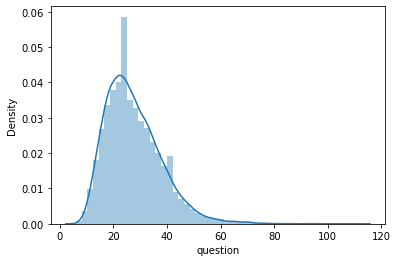

In [432]:
sns.distplot(snokel_train_df_add_header_not_related_header["question"].map(len))

In [439]:
snokel_train_df_add_header_not_related_header_long = snokel_train_df_add_header_not_related_header[snokel_train_df_add_header_not_related_header["question"].map(len) >= 40].copy()

In [442]:
snokel_train_df_add_header_not_related_header_short = snokel_train_df_add_header_not_related_header[snokel_train_df_add_header_not_related_header["question"].map(len) < 40].copy()

In [441]:
snokel_train_df_add_header_not_related_header_long["agg"].value_counts()

0.0    4040
4.0     505
1.0     189
2.0     122
3.0      89
5.0      80
Name: agg, dtype: int64

In [443]:
snokel_train_df_add_header_not_related_header_short["agg"].value_counts()

0.0    31429
4.0     2304
5.0      879
1.0      300
2.0      222
3.0      147
Name: agg, dtype: int64

In [440]:
balanced_accuracy_score(snokel_train_df_add_header_not_related_header_long["agg_combined"], snokel_train_df_add_header_not_related_header_long["simple_prediction"])

0.8952582818396865

In [444]:
balanced_accuracy_score(snokel_train_df_add_header_not_related_header_short["agg_combined"], snokel_train_df_add_header_not_related_header_short["simple_prediction"])

0.8543009455831688

In [485]:
simple_gold_conclusion = snokel_train_df_add_header.apply(simple_total_label_func, axis = 1)

In [486]:
balanced_accuracy_score(snokel_train_df_add_header["agg_combined"], simple_gold_conclusion)

0.8442635719753829

In [491]:
#### remove some header contain string in input.
def simple_label_func(s):
    text_tokens =s.question_cut
    header = list(map(lambda x: x[:x.find("(")] if (not x.startswith("(") and x.endswith(")")) else x ,s.header.split(",")))
    
    #### not contain samples may not match in fuzzy-match, special column mapping in finance,
    ### or "3" to "三"
    fit_collection = ('多少个', '有几个', '总共') + ('总和','一共',) + ('平均数', '均值', '平均值', '平均') + \
    ('最大', '最多', '最大值', '最高') + ('最少', '最小值', '最小', '最低')
    fit_header = []
    for c in header:
        for kw in fit_collection:
            if kw in c:
                start_idx = c.find(kw)
                end_idx = start_idx + len(kw)
                fit_header.append(c[start_idx: end_idx])
                
    input_ = "".join(text_tokens)
    for c in header + fit_header:
        if c in fit_collection:
            continue
        input_ = input_.replace(c, "")
        c0, c1 = c, c
        while c0 and c0 not in fit_collection and len(c0) >= 4:
            c0 = c0[1:]
            if c0 in fit_collection:
                break
            input_ = input_.replace(c0, "")
        while c1 and c1 not in fit_collection and len(c1) >= 4:
            c1 = c1[:-1]
            if c1 in fit_collection:
                break
            input_ = input_.replace(c1, "")
        
    text_tokens = list(jieba.cut(input_))
    
    #cat_6_collection_high_level = ('多少个', '有几个', '总共') + ('总和','一共',) + ("哪些", "查", "数量")
    #cat_6_collection_high_level = ('多少个', '有几个', '总共') + ('总和','一共',)
    ##### 高置信度部分 （作为是否构成使用特殊规则的判断标准）
    #### case 2 部分 （高置信度有效匹配）
    cat_6_collection_high_level =  ('多少个', '有几个', '总共') + ('总和','一共',)
    if any(map(lambda high_level_token: high_level_token in "".join(text_tokens), cat_6_collection_high_level)):
        return 6
    
    #### 够深 够宽 规则部分, change order by header, if header have kws in , lower order
    if any(map(lambda kw: kw in text_tokens, ('平均数', '均值', '平均值', '平均'))):
        return 1
    if any(map(lambda kw: kw in text_tokens, ('最大', '最多', '最大值', '最高'))):
        return 2
    if any(map(lambda kw: kw in text_tokens, ('最少', '最小值', '最小', '最低'))):
        return 3
    
    ##### 低置信度部分
    #### case 2 部分  (低置信度尾部匹配)
    cat_6_collection = ('个', '总共') + ('总和','加','总','一共','和',) + ("哪些", "查", "数量", "数") + ("几",) +\
    ('多少', "多大")
    if any(map(lambda kw: kw in text_tokens, cat_6_collection)):
        return 6
    if any(map(lambda token: "几" in token, text_tokens)):
        return 6
    
    #### special case 部分
    if any(map(lambda kw: kw in text_tokens, ("以上", "大于"))):
        return 2
    if any(map(lambda kw: kw in text_tokens, ("以下", "小于"))):
        return 3
    
    #### 无效匹配
    return 0

In [492]:
def simple_special_func(s):
    text_tokens =s.question_cut
    header = list(map(lambda x: x[:x.find("(")] if (not x.startswith("(") and x.endswith(")")) else x ,s.header.split(",")))
    
    #### not contain samples may not match in fuzzy-match, special column mapping in finance,
    ### or "3" to "三"
    fit_collection = ('多少个', '有几个', '总共') + ('总和','一共',) + ('平均数', '均值', '平均值', '平均') + \
    ('最大', '最多', '最大值', '最高') + ('最少', '最小值', '最小', '最低')
    fit_header = []
    for c in header:
        for kw in fit_collection:
            if kw in c:
                start_idx = c.find(kw)
                end_idx = start_idx + len(kw)
                fit_header.append(c[start_idx: end_idx])
                
    input_ = "".join(text_tokens)
    for c in header + fit_header:
        if c in fit_collection:
            continue
        input_ = input_.replace(c, "")
        c0, c1 = c, c
        while c0 and c0 not in fit_collection and len(c0) >= 4:
            c0 = c0[1:]
            if c0 in fit_collection:
                break
            input_ = input_.replace(c0, "")
        while c1 and c1 not in fit_collection and len(c1) >= 4:
            c1 = c1[:-1]
            if c1 in fit_collection:
                break
            input_ = input_.replace(c1, "")
        
    text_tokens = list(jieba.cut(input_))
    #ic(text_tokens)
    
    #cat_6_collection_high_level = ('多少个', '有几个', '总共') + ('总和','一共',) + ("哪些", "查", "数量")
    #cat_6_collection_high_level = ('多少个', '有几个', '总共') + ('总和','一共',)
    #### case 2 部分 （高置信度有效匹配）
    cat_6_collection_high_level =  ('多少个', '有几个', '总共') + ('总和','一共',)
    if any(map(lambda high_level_token: high_level_token in "".join(text_tokens), cat_6_collection_high_level)):
        return 6
    
    #### 够深 够宽 规则部分 
    if any(map(lambda kw: kw in text_tokens, ('平均数', '均值', '平均值', '平均'))):
        return 1
    if any(map(lambda kw: kw in text_tokens, ('最大', '最多', '最大值', '最高'))):
        return 2
    if any(map(lambda kw: kw in text_tokens, ('最少', '最小值', '最小', '最低'))):
        return 3
    
    return 0

In [493]:
def simple_total_label_func(s):
    is_special = False if simple_special_func(s) == 0 else True
    if not is_special:
        return 0
    return simple_label_func(s)

In [496]:
simple_gold_conclusion = snokel_train_df_add_header.apply(simple_total_label_func, axis = 1)

In [497]:
# 0.8616116961006824 > 0.8442635719753829
# this only test on question_cut not res_cut
balanced_accuracy_score(snokel_train_df_add_header["agg_combined"], simple_gold_conclusion)

0.8616116961006824

In [499]:
snokel_train_df_add_header["agg"].value_counts()

0.0    36514
4.0     2899
5.0      995
1.0      504
2.0      373
3.0      248
Name: agg, dtype: int64

In [501]:
snokel_train_df_add_header[snokel_train_df_add_header["agg"].isin((4, 5))].to_csv("cat6_data.csv", index = False)

In [502]:
cat6_data = snokel_train_df_add_header[snokel_train_df_add_header["agg"].isin((4, 5))].copy()

In [523]:
def cat4_qst_unit(s):
    question = s.question
    unit_kws = ("只", "个", "所", "条", "种")
    qst_kws = ("多少", "几")
    qst_unit_patterns = list(map(lambda t2: "{}{}".format(*t2) ,product(qst_kws, unit_kws)))
    if any(map(lambda p: p in question, qst_unit_patterns)):
        return True
    return False

In [524]:
#cat4_qst_unit(None)

In [525]:
cat6_data[cat6_data["agg"] == 4.0][(1 - cat6_data[cat6_data["agg"] == 4.0].apply(cat4_qst_unit, axis = 1)).astype(bool)]

,question,agg,question_cut,header,agg_combined,simple_prediction
76,我想知道在股市收盘价破六元的股票有多少？,4.0,"[我, 想, 知道, 在, 股市, 收盘价, 破, 六元, 的, 股票, 有, 多少, ？]","股票名称,股票代码,收盘价（元）,周涨跌（%）,市值（亿元）,EPS(TTM),PE(TTM)",6.0,0
642,PE-TTM大于10并且PB大于 1的股票总共有多少？,4.0,"[PE, -, TTM, 大于, 10, 并且, PB, 大于, , 1, 的, 股票, ...","股票代码,股票简称,PE-TTM,PB,PS",6.0,6
644,请问一下PE-TTM大于10并且PB大于 1的股票总共有多少？,4.0,"[请问, 一下, PE, -, TTM, 大于, 10, 并且, PB, 大于, , 1,...","股票代码,股票简称,PE-TTM,PB,PS",6.0,6
971,投资总额大于300并且公里数大于 300的线路总共有哪些？,4.0,"[投资总额, 大于, 300, 并且, 公里, 数, 大于, , 300, 的, 线路, ...","时间,线路,起止城市,公里数（km）,设计时速（km/h）,投资总额（亿元）",6.0,6
972,总共有哪些线路投资总额大于300并且公里数大于 300的？,4.0,"[总共, 有, 哪些, 线路, 投资总额, 大于, 300, 并且, 公里, 数, 大于, ...","时间,线路,起止城市,公里数（km）,设计时速（km/h）,投资总额（亿元）",6.0,6
...,...,...,...,...,...,...
40910,你好啊，那个有多少家公司抽查不合格啊,4.0,"[你好, 啊, ，, 那个, 有, 多少, 家, 公司, 抽查, 不, 合格, 啊]","序号,企业名称,所在省,产品名称,商标,规格型号,生产日期/批号,抽查结果,承检机构",6.0,0
41082,花都区的商品房数量一共是多少,4.0,"[花都区, 的, 商品房, 数量, 一共, 是, 多少]","区域,楼盘,12.30-1.26成交均价,1.27-2.23成交均价,均价相差,变动情况（升...",6.0,6
41166,你帮我查一下平原校区的实验室数,4.0,"[你, 帮, 我查, 一下, 平原, 校区, 的, 实验室, 数]","动物名称,规格型号,需购数量,单位,院系,实验室名称,校区",6.0,0
41517,你知道目前有多少职位是属于管理类型的吗,4.0,"[你, 知道, 目前, 有, 多少, 职位, 是, 属于, 管理, 类型, 的, 吗]","序号,招聘岗位,岗位类别,人数,招聘对象,年龄,专业,学历/学位,专业技术资格",6.0,0


In [505]:
cat6_data[cat6_data["agg"] == 4.0]

,question,agg,question_cut,header,agg_combined,simple_prediction
75,有几只股票的收盘价破了六块了啊？,4.0,"[有, 几只, 股票, 的, 收盘价, 破, 了, 六块, 了, 啊, ？]","股票名称,股票代码,收盘价（元）,周涨跌（%）,市值（亿元）,EPS(TTM),PE(TTM)",6.0,0
76,我想知道在股市收盘价破六元的股票有多少？,4.0,"[我, 想, 知道, 在, 股市, 收盘价, 破, 六元, 的, 股票, 有, 多少, ？]","股票名称,股票代码,收盘价（元）,周涨跌（%）,市值（亿元）,EPS(TTM),PE(TTM)",6.0,0
77,请问有多少只股票的收盘价超过了六块每股？,4.0,"[请问, 有, 多少, 只, 股票, 的, 收盘价, 超过, 了, 六块, 每股, ？]","股票名称,股票代码,收盘价（元）,周涨跌（%）,市值（亿元）,EPS(TTM),PE(TTM)",6.0,0
81,市值高于二十亿的股票有多少只？,4.0,"[市值, 高于, 二十亿, 的, 股票, 有, 多少, 只, ？]","股票名称,股票代码,收盘价（元）,周涨跌（%）,市值（亿元）,EPS(TTM),PE(TTM)",6.0,0
82,请问有几只股票的市值高于二十啊？,4.0,"[请问, 有, 几只, 股票, 的, 市值, 高于, 二十, 啊, ？]","股票名称,股票代码,收盘价（元）,周涨跌（%）,市值（亿元）,EPS(TTM),PE(TTM)",6.0,0
...,...,...,...,...,...,...
41491,有多少所学校是要招小学语文老师的？,4.0,"[有, 多少, 所, 学校, 是, 要, 招, 小学, 语文, 老师, 的, ？]","招聘单位,招聘岗位,开考岗位数,报名人数",6.0,0
41492,帮我查查一共有多少所学校是要招小学语文老师的,4.0,"[帮, 我, 查查, 一共, 有, 多少, 所, 学校, 是, 要, 招, 小学, 语文, ...","招聘单位,招聘岗位,开考岗位数,报名人数",6.0,6
41516,一共有几个管理类的岗位啊,4.0,"[一共, 有, 几个, 管理, 类, 的, 岗位, 啊]","序号,招聘岗位,岗位类别,人数,招聘对象,年龄,专业,学历/学位,专业技术资格",6.0,6
41517,你知道目前有多少职位是属于管理类型的吗,4.0,"[你, 知道, 目前, 有, 多少, 职位, 是, 属于, 管理, 类型, 的, 吗]","序号,招聘岗位,岗位类别,人数,招聘对象,年龄,专业,学历/学位,专业技术资格",6.0,0


In [506]:
cat6_data[cat6_data["agg"] == 5.0]

,question,agg,question_cut,header,agg_combined,simple_prediction
33,你好啊，那个16年和17年商品房销售总额总有多少啊,5.0,"[你好, 啊, ，, 那个, 16, 年, 和, 17, 年, 商品房, 销售总额, 总有,...","None,商品房销售额:累计,同比增速,40大中城市:一线城市,同比增速,40大中城市:二线...",6.0,0
34,诶，那个16年的商品房销售额和那个17年商品房销售额加到一起的话有多少啊,5.0,"[诶, ，, 那个, 16, 年, 的, 商品房, 销售额, 和, 那个, 17, 年, 商...","None,商品房销售额:累计,同比增速,40大中城市:一线城市,同比增速,40大中城市:二线...",6.0,0
35,你能就是帮我算算看16年和17年的商品房销售额一共达到了多少来着,5.0,"[你, 能, 就是, 帮, 我, 算算看, 16, 年, 和, 17, 年, 的, 商品房,...","None,商品房销售额:累计,同比增速,40大中城市:一线城市,同比增速,40大中城市:二线...",6.0,6
372,亚玛顿和四川双马的收盘价加起来是多少,5.0,"[亚玛顿, 和, 四川双马, 的, 收盘价, 加, 起来, 是, 多少]","名称,收盘价,涨跌幅",6.0,0
373,请问一下亚玛顿和四川双马的收盘价总共是多少钱,5.0,"[请问, 一下, 亚玛顿, 和, 四川双马, 的, 收盘价, 总共, 是, 多少, 钱]","名称,收盘价,涨跌幅",6.0,6
...,...,...,...,...,...,...
40990,想要了解的是有一共有多少人报名了科学技术哲学和外国哲学,5.0,"[想要, 了解, 的, 是, 有, 一共, 有, 多少, 人, 报名, 了, 科学技术, 哲...","院系,专业,报名人数,录取人数,其中免试人数,同等学力录取人数",6.0,6
40991,请问一下科学技术哲学和外国哲学的报名人数总和是多少,5.0,"[请问, 一下, 科学技术, 哲学, 和, 外国, 哲学, 的, 报名, 人数, 总和, 是...","院系,专业,报名人数,录取人数,其中免试人数,同等学力录取人数",6.0,6
41475,开心康乐大学和横枝岗社区老年学堂这两个项目一共资助多少啊,5.0,"[开心, 康乐, 大学, 和, 横枝, 岗, 社区, 老年, 学堂, 这, 两个, 项目, ...","序号,区、县级市,项目名称,承办组织,资助金额（万元）",6.0,6
41476,你帮我算算那个开心康乐大学和横枝岗社区老年学堂两个项目加起来资助金额达到多少万啊,5.0,"[你, 帮, 我, 算算, 那个, 开心, 康乐, 大学, 和, 横枝, 岗, 社区, 老年...","序号,区、县级市,项目名称,承办组织,资助金额（万元）",6.0,0
